In [208]:
import pandas as pd
import numpy as np
import spacy
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Flatten, Masking, Dense, Embedding, Input, Reshape
from keras.models import Sequential, Model
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

## Read and preprocess data

In [3]:
# Read preprocessed data
data = pd.read_csv("PreprocessedData.csv", index_col = 0)

/Users/maheshpandit/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13,15,16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Use labels only for top 30 brands. Use label "OTHER" for the rest
data["label"] = data.brand.apply(lambda x: x if x in data.brand.value_counts()[:30].keys() else "OTHER")

In [5]:
#Encode the labels
encoder = LabelEncoder()
labels = to_categorical(encoder.fit_transform(data.label))

In [6]:
data.head().T

,20000,20001,20002,20003,20004,20005,20006,20007,20008,20009
product_id,01EEBGWGXVA6QT2YNKR583WNPM,01EEBGWH0QA1DEVRY8D8WEYQ49,01EEBGWH4FQC26RQ23R8J483T9,01EEBGWRHWR7XMT0SMRZH91R4Q,01EEBGWRN5D75PAHKE8YNZ2P9G,01EEBGWRR3G7WC84JKNHMVGECR,01EEBGWTTV1J3V63G8NE10FSKF,01EEBGWW6AQ2H84WR1VGQPHF1J,01EEBGWXBF4NNC4P3NMVA7D3ZT,01EEBGWYKVVD087V0ZWHJEQM54
brand,Intentionally Blank,Intentionally Blank,Intentionally Blank,Intentionally Blank,Intentionally Blank,Intentionally Blank,Intentionally Blank,Intentionally Blank,Intentionally Blank,Intentionally Blank
brand_category,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
name,ARCHIVE 2305,ARCHIVE 2307,ARCHIVE 231,ARCHIVE 2311,ARCHIVE 2314,ARCHIVE 232,ARCHIVE 233,ARCHIVE 234,ARCHIVE 235,ARCHIVE 235
details,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
created_at,2020-07-28 20:12:41.267 UTC,2020-07-28 20:12:41.334 UTC,2020-07-28 20:12:41.479 UTC,2020-07-28 20:12:49.075 UTC,2020-07-28 20:12:49.181 UTC,2020-07-28 20:12:49.275 UTC,2020-07-28 20:12:51.411 UTC,2020-07-28 20:12:52.801 UTC,2020-07-28 20:12:53.992 UTC,2020-07-28 20:12:55.283 UTC
brand_canonical_url,https://intentionallyblank.myshopify.com/produ...,https://intentionallyblank.myshopify.com/produ...,https://intentionallyblank.myshopify.com/produ...,https://intentionallyblank.myshopify.com/produ...,https://intentionallyblank.myshopify.com/produ...,https://intentionallyblank.myshopify.com/produ...,https://intentionallyblank.myshopify.com/produ...,https://intentionallyblank.myshopify.com/produ...,https://intentionallyblank.myshopify.com/produ...,https://intentionallyblank.myshopify.com/produ...
description,NAVY BLUE DRESS WITH FLORAL DETAIL,fly track pants,FLORAL HALTER DRESS WITH EMBELLISHED BODICE. S...,grey wool felt vest,mini chevron blazer,NaN,NaN,NaN,NaN,NaN
brand_description,NAVY BLUE DRESS WITH FLORAL DETAIL,fly track pants,FLORAL HALTER DRESS WITH EMBELLISHED BODICE\n\...,grey wool felt vest,mini chevron blazer,NaN,NaN,NaN,NaN,NaN
brand_name,ARCHIVE 2305,ARCHIVE 2307,ARCHIVE 231,ARCHIVE 2311,ARCHIVE 2314,ARCHIVE 232,ARCHIVE 233,ARCHIVE 234,ARCHIVE 235,ARCHIVE 235


In [7]:
data.isna().sum()

product_id                 0
brand                      0
brand_category           459
name                       1
details                52155
created_at                 0
brand_canonical_url        0
description            10121
brand_description      10121
brand_name                 1
product_active             0
materialclothing           0
style                  57598
primarycolor               0
occasion               57600
category               57576
drycleanonly           58717
sizing                 58566
gender                 57598
fit                    58558
sleevelength           59414
product_category       24576
made_in_country            0
colors_temp            41079
materials_temp         29839
details_stemmed        52155
description_stemmed    10121
label                      0
dtype: int64

In [8]:
# Fill NaN in feature columns
data.description = data.description.fillna("UNAVAILABLE")
data.product_category = data.product_category.fillna("UNKNOWN_CATEGORY")
data.name = data.name.fillna("UNKNOWN_NAME")

In [9]:
# Remove stopwords from description column
docs = data.description
nlp = spacy.load('en_core_web_sm')
stopwords_removed_docs = list(
map(lambda doc: " ".join([token.text for token in nlp(doc) if not token.is_stop]), docs))

In [11]:
# Remove stopwords from name column
docs_2 = data.name
stopwords_removed_docs_2 = list(
map(lambda doc: " ".join([token.text for token in nlp(doc) if not token.is_stop]), docs_2))

In [12]:
def comma_separate(txt_list):
    """ Converts strings with commas to a Python list """
    return list(map(lambda x: (" ").join(x.split(",")), list( txt_list )))

## Tokenize text

In [106]:
# All tokens that are not in the Vocabulary (top 10000 words) are replaced by "UNKNOWN TOKEN"
tokenizer = Tokenizer(num_words=10000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts( stopwords_removed_docs + stopwords_removed_docs_2 + comma_separate( data.primarycolor ) + comma_separate( data.materialclothing ) + list( data.made_in_country ) + list( data.product_category ) )

In [126]:
def integer_encode_documents(docs, tokenizer):
    """ Integer encode documents using tokenizer that is passed as input """
    return tokenizer.texts_to_sequences(docs)

## Pad the documents

Use histograms of feature lengths to determine the most suitable maximum length for each feature

(array([38024., 16901.,  4900.,   855.,   169.,   104.,    92.,   149.,
           75.,    86.]),
 array([  1. ,  53.7, 106.4, 159.1, 211.8, 264.5, 317.2, 369.9, 422.6,
        475.3, 528. ]),
 <a list of 10 Patch objects>)

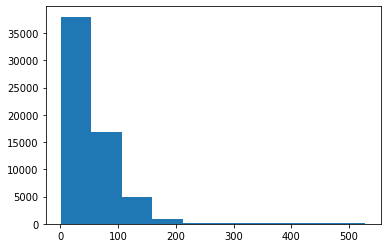

In [16]:
import matplotlib.pyplot as plt
plt.hist(list(map(lambda x: len(x.split()), docs)))

(array([3.4264e+04, 1.7574e+04, 7.0270e+03, 1.7440e+03, 5.5900e+02,
        1.5000e+02, 3.3000e+01, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 1. ,  3.1,  5.2,  7.3,  9.4, 11.5, 13.6, 15.7, 17.8, 19.9, 22. ]),
 <a list of 10 Patch objects>)

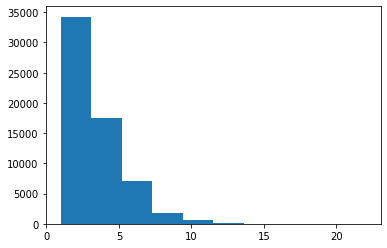

In [17]:
plt.hist(list(map(lambda x: len(x.split()), docs_2)))

(array([5.5705e+04, 4.4840e+03, 8.7900e+02, 1.7700e+02, 6.1000e+01,
        3.5000e+01, 7.0000e+00, 3.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

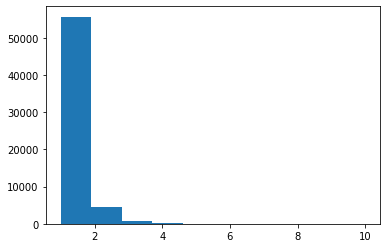

In [18]:
plt.hist(list(map(lambda x: len(x.split(",")), list(data.primarycolor))))

(array([4.9999e+04, 0.0000e+00, 8.9530e+03, 0.0000e+00, 1.8100e+03,
        0.0000e+00, 4.2700e+02, 0.0000e+00, 1.5000e+02, 1.6000e+01]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

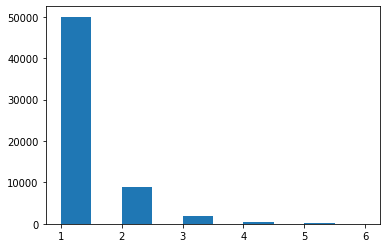

In [19]:
plt.hist(list(map(lambda x: len(x.split(",")), list(data.materialclothing))))

(array([53228.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  8127.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <a list of 10 Patch objects>)

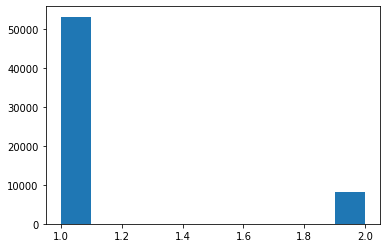

In [20]:
plt.hist(list(map(lambda x: len(x.split()), data.product_category)))

In [128]:
def pad(sequence, tokenizer, max_length):
    """ Integer encodes and pads documents to max length passed as input"""
    encoded_docs = integer_encode_documents(sequence, tokenizer)
    return pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [22]:
# Pad the documents according to max lengths determined from histograms
padded_docs_1 = pad(stopwords_removed_docs, tokenizer, 150)
padded_docs_2 = pad( stopwords_removed_docs_2, tokenizer, 7 )
padded_docs_3 = pad( comma_separate( data.materialclothing ), tokenizer, 3 )
padded_docs_4 = pad( comma_separate( data.primarycolor ), tokenizer, 3 )
padded_docs_5 = pad( data.made_in_country, tokenizer, 2 )
padded_docs_6 = pad( data.product_category, tokenizer, 2 )

In [259]:
# Concatenate all padded encodings together
concatenated_padded_docs = [0] * len(padded_docs_1)
for i in range(len(padded_docs_1)):
    concatenated_padded_docs[i] = np.array(list( padded_docs_1[i] ) + list( padded_docs_2[i] )  + list( padded_docs_3[i] ) + list( padded_docs_4[i] )+ list( padded_docs_5[i] ) + list( padded_docs_6[i] ) ) 
concatenated_padded_docs = np.array( concatenated_padded_docs )

## Split data into training and testing sets

In [260]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(concatenated_padded_docs, labels, test_size=0.2, stratify = labels)

## Load GloVe Vectors

In [91]:
def load_glove_vectors():
    embeddings_index = {}
    with open('glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


## Load Embeddings

In [262]:
# Increase vocabulary size by 10% so that custom tokens can be stored during processing
VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

In [266]:
# this is the sum of lengths of individual features
MAX_SEQUENCE_LENGTH = 167

## Test RNN model

In [255]:
def make_binary_classification_rnn_model(plot=False):
    """ Create RNN Model """
    model =  Sequential()
    model.add(Embedding(embedding_matrix.shape[0], 
                    100, 
                    weights=[embedding_matrix], 
                    input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(64))
    model.add(Dense(31, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [143]:
from keras.utils.vis_utils import plot_model

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 159, 100)          3673100   
_________________________________________________________________
masking_8 (Masking)          (None, 159, 100)          0         
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 64)                10560     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 31)                2015      
Total params: 3,689,835
Trainable params: 16,735
Non-trainable params: 3,673,100
_________________________________________________________________
None
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab

In [96]:
data["label"].value_counts(normalize=True)

OTHER                    0.254079
7 For All Mankind        0.146867
Rails                    0.046679
Intentionally Blank      0.041301
A.L.C.                   0.034097
Rachel Comey             0.033917
Misa                     0.033086
Studio 189               0.031880
ASTR the Label           0.031652
lemlem                   0.029680
Simon Miller             0.023649
Cynthia Rowley           0.021954
Outerknown               0.021808
Chufy                    0.019705
Faherty                  0.019624
M.M.LaFleur              0.019428
Janessa Leone            0.018238
Araks                    0.017619
Sea                      0.017162
BROCHU WALKER            0.016315
Tanya Taylor             0.016152
Clare V.                 0.015027
Nili Lotan               0.011686
Les Girls Les Boys       0.011328
Prism                    0.010871
Sandy Liang              0.010806
6397                     0.010627
Ancient Greek Sandals    0.010073
Alo Yoga                 0.008557
Collina Strada

From the data above, we can see that the baseline accuracy is 25%

In [144]:
# fit the model
history = model.fit(X_train, y_train, validation_split = 0.1, epochs=10, verbose=1)

Epoch 1/25
1381/1381 [==============================] - 46s 32ms/step - loss: 2.2132 - accuracy: 0.4207 - val_loss: 1.3959 - val_accuracy: 0.6150
Epoch 2/25
1381/1381 [==============================] - 44s 32ms/step - loss: 1.3159 - accuracy: 0.6338 - val_loss: 1.1803 - val_accuracy: 0.6751
Epoch 3/25
1381/1381 [==============================] - 44s 32ms/step - loss: 1.1077 - accuracy: 0.6932 - val_loss: 1.1081 - val_accuracy: 0.6948
Epoch 4/25
1381/1381 [==============================] - 43s 31ms/step - loss: 1.0033 - accuracy: 0.7184 - val_loss: 1.0726 - val_accuracy: 0.6997
Epoch 5/25
1381/1381 [==============================] - 44s 32ms/step - loss: 0.9087 - accuracy: 0.7433 - val_loss: 0.9852 - val_accuracy: 0.7268
Epoch 6/25
1381/1381 [==============================] - 43s 31ms/step - loss: 0.8243 - accuracy: 0.7682 - val_loss: 0.9770 - val_accuracy: 0.7244
Epoch 7/25
1381/1381 [==============================] - 44s 32ms/step - loss: 0.8073 - accuracy: 0.7697 - val_loss: 0.8797 -

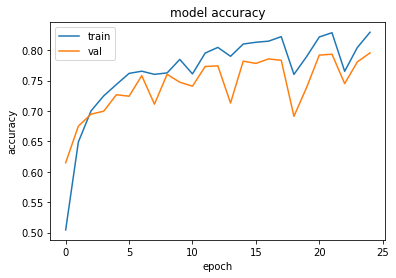

In [145]:
def plot_fit_history(history):
    """ Plot graph of fitting history for the model """
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_fit_history(history)

In [280]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

384/384 [==============================] - 5s 13ms/step - loss: 0.3285 - accuracy: 0.9201
Accuracy: 75.013359


## Test LSTM Model

In [226]:
def make_lstm_classification_model(plot=False):
    """ Create LSTM model """
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0], 
                    100, 
                    weights=[embedding_matrix], 
                    input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(64))
    model.add(Dense(31, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [267]:
model = make_lstm_classification_model()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_60 (Embedding)     (None, 167, 100)          3673100   
_________________________________________________________________
masking_46 (Masking)         (None, 167, 100)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_42 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_43 (Dense)             (None, 31)                2015      
Total params: 3,721,515
Trainable params: 48,415
Non-trainable params: 3,673,100
_________________________________________________________________


In [268]:
# fit the model
history = model.fit(X_train, y_train,validation_split = 0.1, epochs=10, verbose=1)

Epoch 1/10
1381/1381 [==============================] - 101s 70ms/step - loss: 1.9219 - accuracy: 0.4907 - val_loss: 0.8402 - val_accuracy: 0.7623
Epoch 2/10
1381/1381 [==============================] - 89s 64ms/step - loss: 0.7348 - accuracy: 0.7946 - val_loss: 0.5897 - val_accuracy: 0.8348
Epoch 3/10
1381/1381 [==============================] - 82s 59ms/step - loss: 0.5003 - accuracy: 0.8604 - val_loss: 0.4500 - val_accuracy: 0.8715
Epoch 4/10
1381/1381 [==============================] - 85s 61ms/step - loss: 0.3823 - accuracy: 0.8945 - val_loss: 0.3806 - val_accuracy: 0.8888
Epoch 5/10
1381/1381 [==============================] - 85s 62ms/step - loss: 0.3145 - accuracy: 0.9122 - val_loss: 0.4116 - val_accuracy: 0.8882
Epoch 6/10
1381/1381 [==============================] - 87s 63ms/step - loss: 0.2642 - accuracy: 0.9265 - val_loss: 0.3145 - val_accuracy: 0.9096
Epoch 7/10
1381/1381 [==============================] - 88s 63ms/step - loss: 0.2268 - accuracy: 0.9359 - val_loss: 0.3091 

In [269]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

384/384 [==============================] - 5s 12ms/step - loss: 0.3351 - accuracy: 0.9155
Accuracy: 91.549182


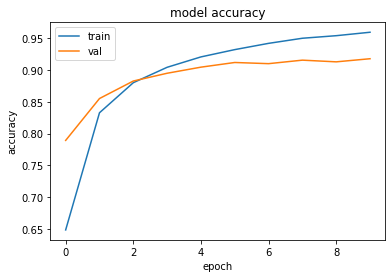

In [229]:
plot_fit_history(history)

### Use 5-fold Cross-Validation to test the performance of RNNs and LSTMs

In [270]:
def stratified_test(splits = 5, model_type = "RNN"):
    """ Create stratified tests, create and run models """
    skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
    accuracy_train = []
    accuracy_test = []
    for train_index, test_index in skf.split(concatenated_padded_docs,list(data.label)):
        X_train = np.array([concatenated_padded_docs[i] for i in train_index])
        y_train = np.array([labels[i] for i in train_index])
        X_test = np.array([concatenated_padded_docs[i] for i in test_index])
        y_test = np.array([labels[i] for i in test_index])
        if model_type == "RNN":
            model = make_binary_classification_rnn_model()
        else:
            model = make_lstm_classification_model()
        history = model.fit(X_train, y_train, epochs=10, verbose=0)
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        # Use training accuracy from last iteration for training
        accuracy_train.append(history.history['accuracy'][-1]) 
        accuracy_test.append(accuracy)
    train_avg = sum(accuracy_train)/len(accuracy_train)
    test_avg = sum(accuracy_test)/len(accuracy_test)
    print("The training accuracies for {} model are {}\n".format(model_type, accuracy_train))
    print("The validation accuracies for {} model are {}\n".format(model_type, accuracy_test))
    print("Average training accuracy is {} and average testing accuracy is {}".format(train_avg, test_avg))

In [275]:
stratified_test(5, "RNN")

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_75 (Embedding)     (None, 167, 100)          3673100   
_________________________________________________________________
masking_61 (Masking)         (None, 167, 100)          0         
_________________________________________________________________
simple_rnn_46 (SimpleRNN)    (None, 64)                10560     
_________________________________________________________________
dense_72 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_73 (Dense)             (None, 31)                2015      
Total params: 3,689,835
Trainable params: 16,735
Non-trainable params: 3,673,100
_________________________________________________________________
Model: "sequential_37"
_________________________________________________________________
Layer (type)   

In [274]:
stratified_test(5, "LSTM")

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_70 (Embedding)     (None, 167, 100)          3673100   
_________________________________________________________________
masking_56 (Masking)         (None, 167, 100)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_62 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_63 (Dense)             (None, 31)                2015      
Total params: 3,721,515
Trainable params: 48,415
Non-trainable params: 3,673,100
_________________________________________________________________
Model: "sequential_32"
_________________________________________________________________
Layer (type)   